# Square Root Approximation of the Fokker-Planck Equation

In [ ]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import clippedVoronoi
from sqra_functions import generate_random_voronoi, generate_grid_voronoi, adjacency_random_voronoi, adjacency_matrix_grid, sqra_random_voronoi, sqra_grid_voronoi
from scipy.cluster.vq import vq, kmeans, whiten
from scipy.spatial import Delaunay, delaunay_plot_2d
import matplotlib.cm as cm

import itertools
from scipy.sparse.linalg import expm, expm_multiply

font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

adjacency_matrix_grid(10, 20, periodic=False)

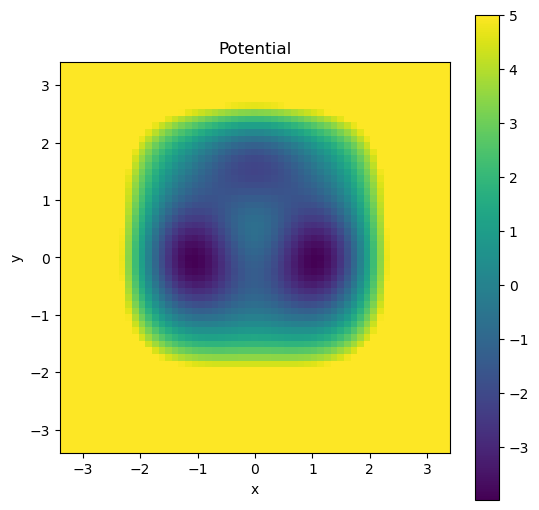

In [2]:
# Potential energy function
def V(x, y):
    #return (x**2 - 1)**2 + 0.5*y * x + y**2     # kJ mol-1
    return 3 * np.exp(-x ** 2 - (y - 1/3) ** 2) \
    - 3 * np.exp(-x ** 2 - (y - 5/3) ** 2) \
    - 5 * np.exp(-(x - 1) ** 2 - y ** 2) \
    - 5 * np.exp(-(x + 1) ** 2 - y ** 2) \
    + 0.2 * x ** 4 \
    + 0.2 * (y - 1/3) ** 4
    
# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
mass  = 1           # amu
gamma = 1           # ps-1

D     = kB * T / mass / gamma # nm2 ps-1
sigma = np.sqrt(2 * D)
beta  = 1 / kB / T

# Grid
nd     =  2  # Number of dimensions
xbins  = 60  # x boundaries
xmin   = -3.4
xmax   =  3.4

ybins  = 60  # y boundaries
ymin   = -3.4
ymax   =  3.4


xedges = np.linspace(xmin, xmax, xbins)  # array with x edges
dx     = xedges[1] - xedges[0]
x      = xedges[:-1] + (dx / 2)                # array with x centers
xbins  = xbins - 1

yedges = np.linspace(ymin, ymax, ybins)  # array with y edges
dy     = yedges[1] - yedges[0]
y      = yedges[:-1] + (dy / 2)                # array with y centers
ybins  = ybins - 1

Nbins  = xbins*ybins                      # number of bins

grid = np.meshgrid(x,y)


fig, ax1 = plt.subplots(1, 1,figsize=(16*in2cm, 16*in2cm))  

pos = ax1.pcolor(grid[0], grid[1], V(grid[0], grid[1]), shading='auto', vmax=5)
ax1.set_title('Potential')
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(pos, ax=ax1)

In [4]:
Ncellsarray = np.array([16,25, 49, 81, 121, 169])

kappa      = np.zeros((len(Ncellsarray), 6))
kappa_grid = np.zeros((len(Ncellsarray), 6))


for N, Ncells in enumerate(Ncellsarray):
    print("Number of cells: ", Ncells)

    xcenters, ycenters, vor                        = generate_random_voronoi(Ncells, xmin, xmax, ymin, ymax)
    xcenters_grid, ycenters_grid, dx, dy, vor_grid = generate_grid_voronoi(Ncells, xmin, xmax, ymin, ymax)

    A, Vol, h, S                           = adjacency_random_voronoi(Ncells, vor)
    A_grid                                 = adjacency_matrix_grid(int(np.sqrt(Ncells)), 2, periodic=False)

    Q      = sqra_random_voronoi(Ncells, xcenters, ycenters, beta, D, V, A, Vol, h, S)
    Q_grid = sqra_grid_voronoi(Ncells, xcenters_grid, ycenters_grid, dx, dy, beta, D, V, A_grid)

    # Number of eigenvectors
    Nevecs = 6

    # Eigenvalue problem
    evals, evecs = scipy.sparse.linalg.eigs(Q.T, Nevecs, which='LR')
    evals = np.real(evals)
    kappa[N,:] = evals

    # Eigenvalue problem
    evals_grid, evecs_grid = scipy.sparse.linalg.eigs(Q_grid.T, Nevecs, which='LR')
    evals_grid = np.real(evals_grid)
    kappa_grid[N,:] = evals_grid


Number of cells:  16
Number of cells:  25
Number of cells:  49
Number of cells:  81
Number of cells:  121
Number of cells:  169


(-8.0, 0.1)

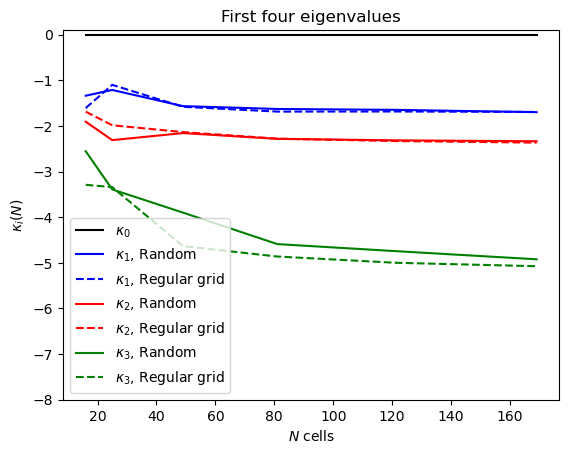

In [5]:
plt.plot(Ncellsarray, kappa[:,0], 'k', label=r'$\kappa_0$')

plt.plot(Ncellsarray, kappa[:,1], 'b', label=r'$\kappa_1$, Random')
plt.plot(Ncellsarray, kappa_grid[:,1], 'b--', label=r'$\kappa_1$, Regular grid')
plt.plot(Ncellsarray, kappa[:,2], 'r', label=r'$\kappa_2$, Random')
plt.plot(Ncellsarray, kappa_grid[:,2], 'r--', label=r'$\kappa_2$, Regular grid')
plt.plot(Ncellsarray, kappa[:,3], 'g', label=r'$\kappa_3$, Random')
plt.plot(Ncellsarray, kappa_grid[:,3], 'g--', label=r'$\kappa_3$, Regular grid')
plt.xlabel(r'$N$ cells')
plt.ylabel(r'$\kappa_i(N)$')
plt.title('First four eigenvalues')
plt.legend()
plt.ylim((-8,0.1))